<a href="https://colab.research.google.com/github/okuyama-leo/google-colab/blob/main/textmining_colab_workshop_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# テキストマイニングワーク用分析ノート（Google Colab用）

> 引用を追加



このノートは，ゼミイベントで実施した偏愛マップ対話の録音データを使って，
**書き起こし → 語句の頻度分析 → 共起ネットワーク分析 → ワードクラウド作成** を行うためのテンプレートです。


想定データ: スマートフォンで録音した `m4a / mp3 / wav` などの音声ファイル

メモ：時間がかかる作業（音声ファイルのアップロード：30分100MB（500Mbps回線）で2分，Whisperのロード：30秒，Whisperの書き起こし：3分）

## 使い方（先に全体像）

1. ランタイムを起動し，Pythonコードを実行できるようにします。

2. このノートを上から順に実行します。

3. 音声ファイルをアップロードします。

4. 自動で日本語書き起こしを作ります。

5. 単語頻度・共起ネットワーク・ワードクラウドを作ります。

6. 最後にCSVや画像をダウンロードします。

## ランタイムの起動
はじめに，コードを実行できるようにします。

*   右上の「接続」と書かれたボタンの横にある▼を押し「ランタイムのタイプを選択」を押し，ハードウェア アクセラレータで「T4 GPU」を選択します。（これにより高速で書き起こしが実行できるようになります。）
*   その後「接続」ボタンを押します。

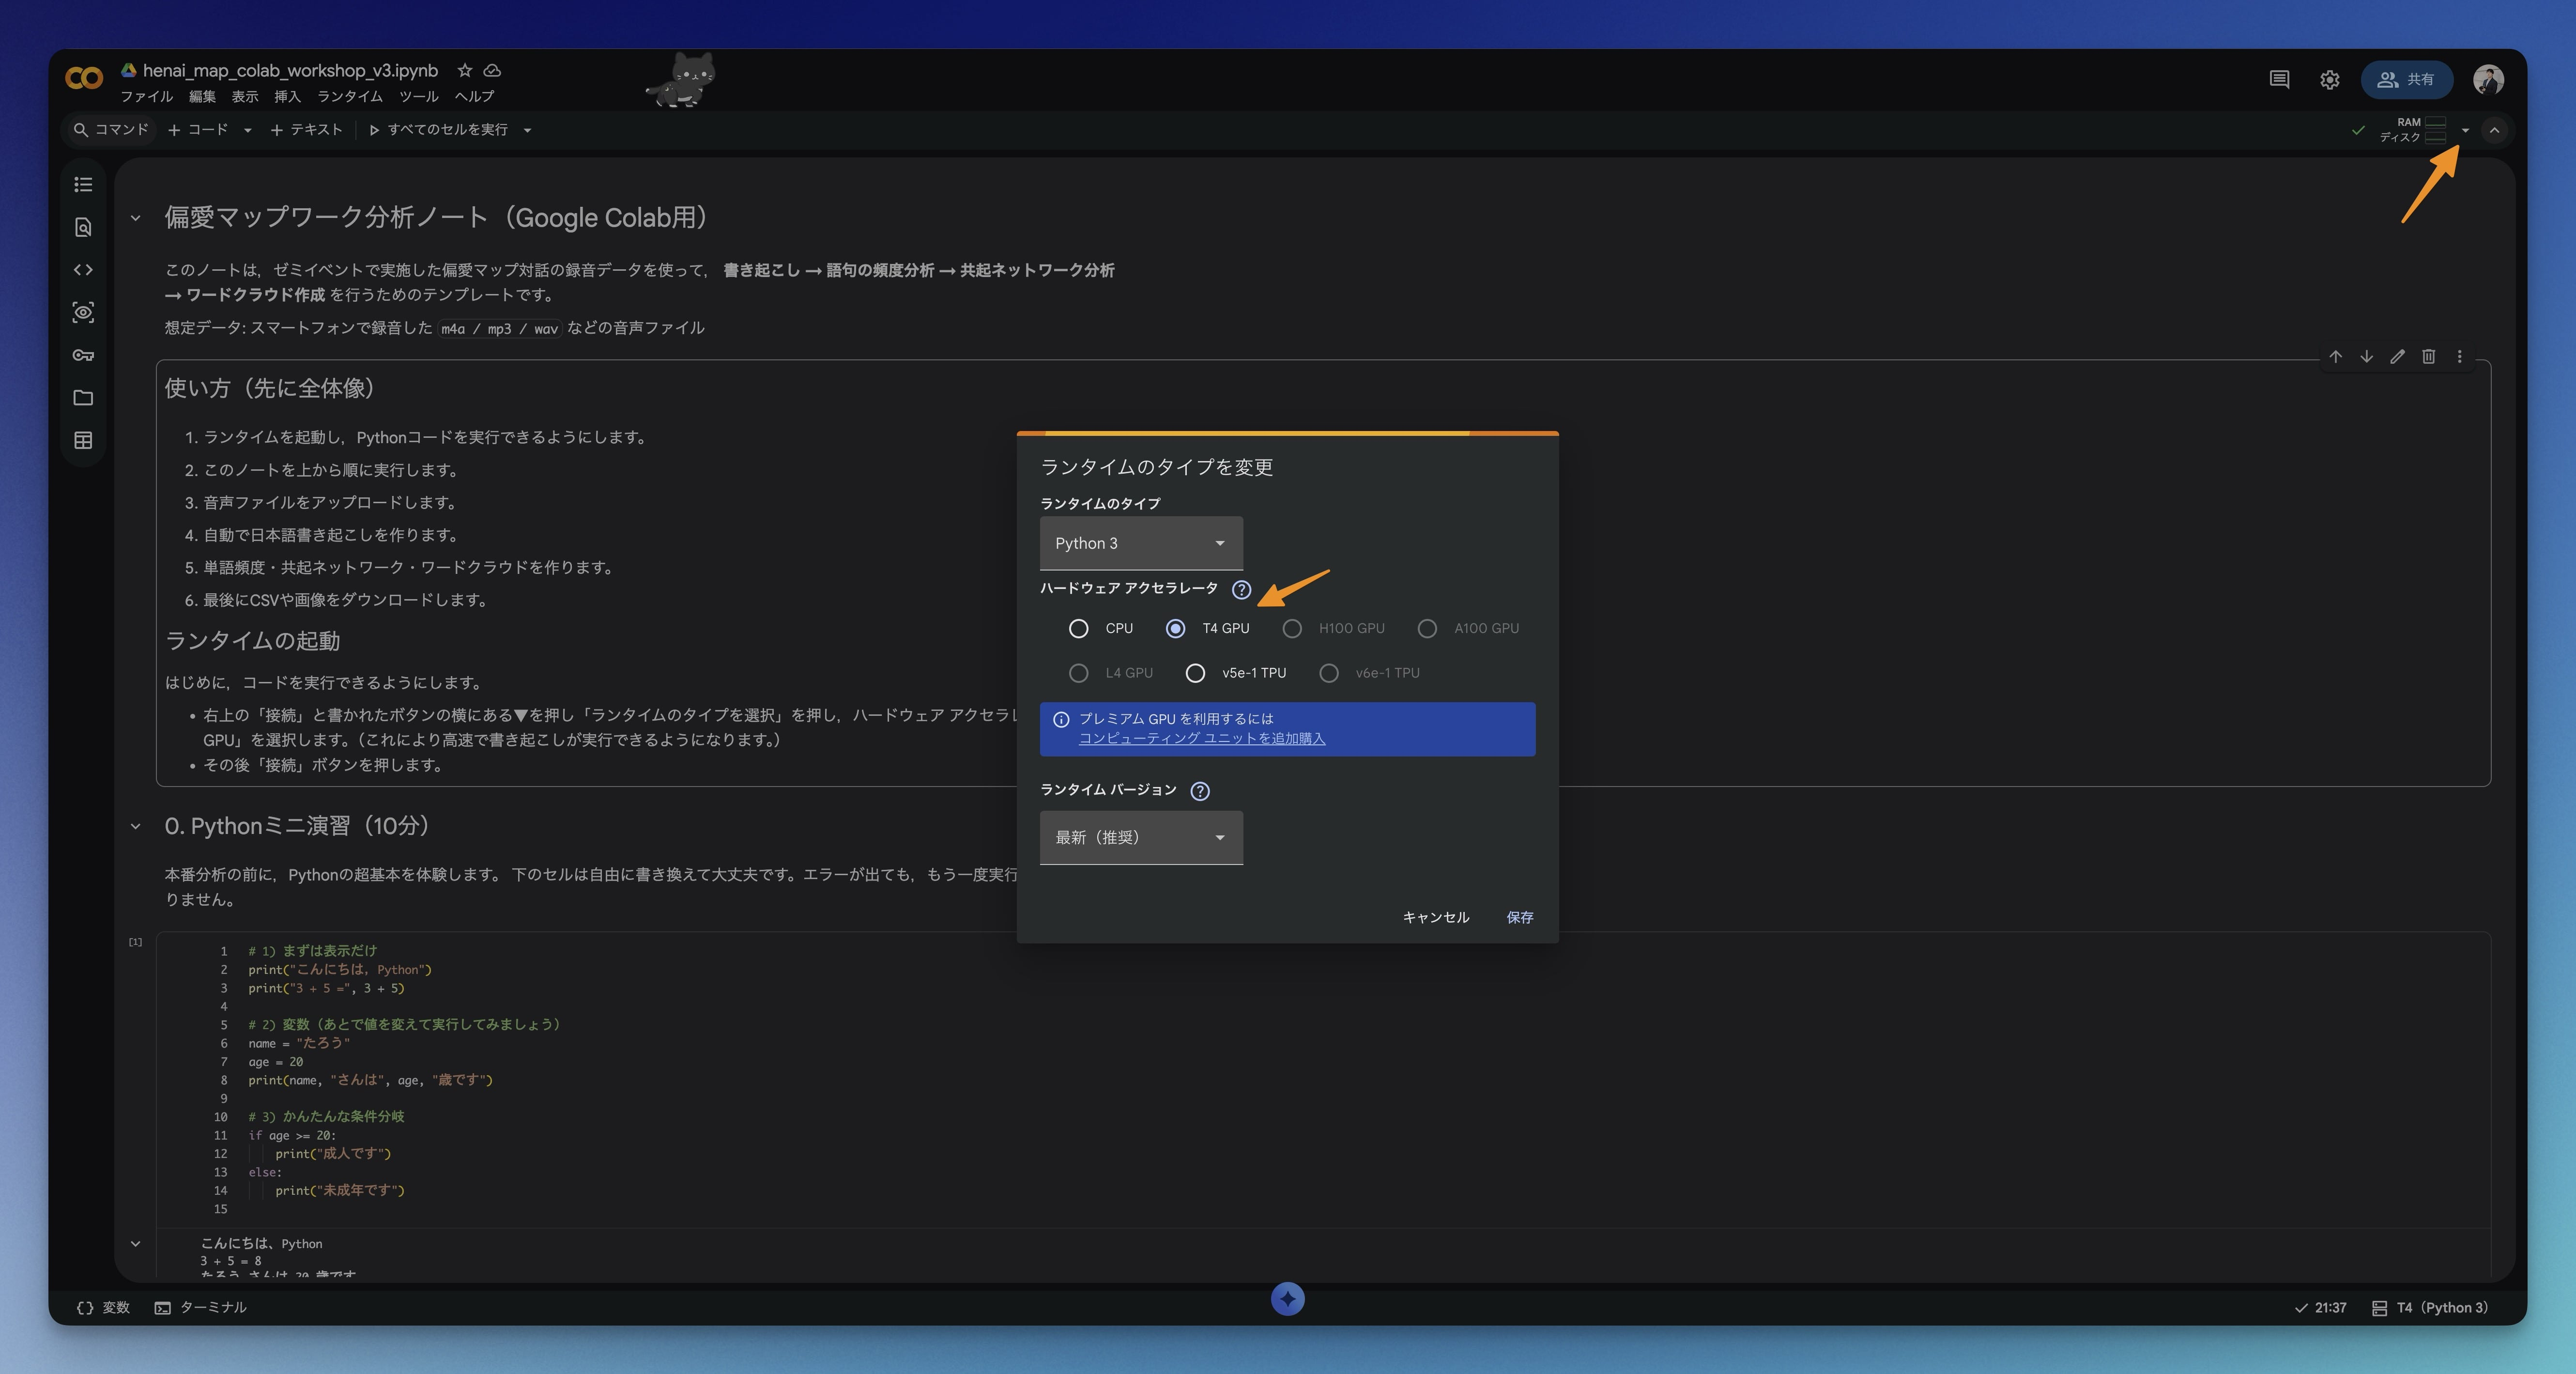

## 0. Pythonミニ演習（10分）
本番分析の前に，Pythonの超基本を体験します。
下のセルは自由に書き換えて大丈夫です。エラーが出ても，もう一度実行し直せば問題ありません。

In [ ]:
# 1) まずは表示だけ
print("こんにちは，Python")
print("3 + 5 =", 3 + 5)

# 2) 変数（あとで値を変えて実行してみましょう）
name = "たろう"
age = 20
print(name, "さんは", age, "歳です")

# 3) かんたんな条件分岐
if age >= 20:
    print("成人です")
else:
    print("未成年です")


こんにちは、Python
3 + 5 = 8
たろう さんは 20 歳です
成人です


In [ ]:
# 4) リストと繰り返し（for）
fruits = ["りんご", "みかん", "バナナ"]

print("好きな果物リスト")
for i, fruit in enumerate(fruits, start=1):
    print(f"{i}個目: {fruit}")

# 5) かんたんな集計（合計）
scores = [70, 85, 90]
total = sum(scores)
average = total / len(scores)

print("合計点:", total)
print("平均点:", average)


好きな果物リスト
1個目: りんご
2個目: みかん
3個目: バナナ
合計点: 245
平均点: 81.66666666666667


,ad_spend,sales
0,2.0,18.0
1,3.0,21.0
2,4.0,25.0
3,5.0,27.0
4,6.0,31.0
5,7.0,34.0
6,8.0,38.0
7,9.0,40.0
8,10.0,43.0
9,11.0,47.0


相関係数: 0.999
回帰式: sales = 3.19 * ad_spend + 11.68
決定係数 R^2: 0.998
広告費 12 万円のときの予測売上: 49.9 万円


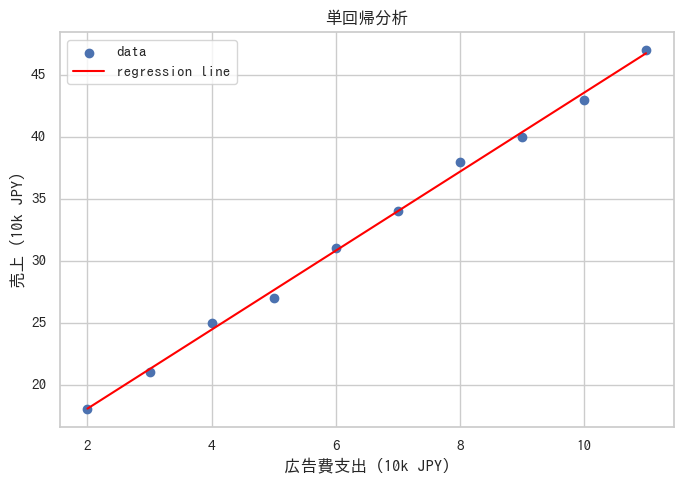

In [ ]:
# 6) かんたんな統計分析（単回帰）
# 例: マーケティングでよくある『広告費が増えると売上はどう変わるか？』を確認します。
# ここでは，相関係数と単回帰（1本の直線）を使います。

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# サンプルデータ（広告費: 万円, 売上: 万円）
ad_spend = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype=float)
sales = np.array([18, 21, 25, 27, 31, 34, 38, 40, 43, 47], dtype=float)

df_ex = pd.DataFrame({"ad_spend": ad_spend, "sales": sales})
display(df_ex)

# 1) 相関係数（-1〜1）
corr = np.corrcoef(ad_spend, sales)[0, 1]
print(f"相関係数: {corr:.3f}")

# 2) 単回帰: sales = slope * ad_spend + intercept
slope, intercept = np.polyfit(ad_spend, sales, 1)
pred = slope * ad_spend + intercept

# 決定係数R^2（1に近いほど当てはまりが良い）
ss_res = np.sum((sales - pred) ** 2)
ss_tot = np.sum((sales - np.mean(sales)) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"回帰式: sales = {slope:.2f} * ad_spend + {intercept:.2f}")
print(f"決定係数 R^2: {r2:.3f}")

# 3) 予測の例（広告費を12万円にした場合）
new_ad_spend = 12
pred_sales = slope * new_ad_spend + intercept
print(f"広告費 {new_ad_spend} 万円のときの予測売上: {pred_sales:.1f} 万円")

# 4) 散布図と回帰直線
plt.figure(figsize=(7, 5))
plt.scatter(ad_spend, sales, label="data")
plt.plot(ad_spend, pred, color="red", label="regression line")
plt.title("単回帰分析")
plt.xlabel("広告費支出 (10k JPY)")
plt.ylabel("売上 (10k JPY)")
plt.legend()
plt.tight_layout()
plt.show()


---
## 1. 分析の準備（最初に1回だけ）
必要なライブラリをインストールします。

- `openai-whisper`: 音声書き起こし
- `janome`: 日本語の単語分割
- `networkx`: 共起ネットワーク
- `wordcloud`: ワードクラウド

In [ ]:
# 警告が出ることがあるが処理自体は実行可能
!apt-get -qq update
!apt-get -qq install -y ffmpeg fonts-ipafont-gothic

# 依存関係の衝突を避けるため，Colab互換バージョンを明示
!pip -q install -U openai-whisper janome networkx wordcloud seaborn==0.13.2 matplotlib==3.10.0 pandas==2.2.2

print("セットアップが完了しました。")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 118.0 MB/s eta 0:00:00
セットアップが完了しました。


In [ ]:
# 以降で使うライブラリを読み込みます
import os
import re
import itertools
from collections import Counter

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
import networkx as nx
import whisper

from janome.tokenizer import Tokenizer
from wordcloud import WordCloud

from google.colab import files

# 日本語フォントを先に設定しておく（棒グラフ・共起ネットワークの文字化け対策）
JP_FONT_CANDIDATES = [
    "/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf",
    "/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf"
]
JP_FONT_PATH = next((p for p in JP_FONT_CANDIDATES if os.path.exists(p)), None)

if JP_FONT_PATH is not None:
    font_manager.fontManager.addfont(JP_FONT_PATH)
    JP_FONT_NAME = font_manager.FontProperties(fname=JP_FONT_PATH).get_name()
    mpl.rcParams["font.family"] = JP_FONT_NAME
    mpl.rcParams["axes.unicode_minus"] = False
    print(f"日本語フォントを設定しました: {JP_FONT_NAME}")
else:
    JP_FONT_NAME = None
    print("警告: 日本語フォントが見つかりません。セットアップセルを再実行してください。")

sns.set_theme(style="whitegrid")
if JP_FONT_NAME is not None:
    mpl.rcParams["font.family"] = JP_FONT_NAME
print("ライブラリの読み込み完了")


日本語フォントを設定しました: IPAGothic
ライブラリの読み込み完了


## 2. 録音データをColabにアップロード

**分析で使うために，録音データをPC内の任意の場所に保存しておいてください。**

### スマホからPCへの取り込み例
- iPhone: AirDrop / USB / iCloud Drive
- Android: USB / Google Drive


下のセルを実行すると，ファイル選択ダイアログが開きます。

In [ ]:
uploaded = files.upload()

# 音声として扱う拡張子
audio_exts = (".m4a", ".mp3", ".wav", ".mp4", ".mpeg", ".aac", ".flac", ".ogg", ".webm")
audio_files = [f for f in uploaded.keys() if f.lower().endswith(audio_exts)]

print("アップロードされた音声ファイル数:", len(audio_files))
print(audio_files)

if len(audio_files) == 0:
    raise ValueError("音声ファイルが見つかりません。対応拡張子のファイルをアップロードしてください。")


Saving ライブ配信_自民党 高市総裁 記者会見.m4a to ライブ配信_自民党 高市総裁 記者会見.m4a
アップロードされた音声ファイル数: 1
['ライブ配信_自民党 高市総裁 記者会見.m4a']


## 3. 日本語書き起こし（Whisper）
Whisperモデルで音声をテキスト化します。

- モデルサイズは `tiny / base / small / medium / large` から選べます
- 速度重視: `tiny` / `base`
- 精度重視: `small` 以上

最初の読み込みに少し時間がかかります。

In [ ]:
# モデルサイズは必要に応じて変更してください
MODEL_SIZE = "small"  # 候補: tiny, base, small, medium, large

model = whisper.load_model(MODEL_SIZE)
print(f"Whisperモデル ({MODEL_SIZE}) を読み込みました。")


100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 115MiB/s]


Whisperモデル (small) を読み込みました。


In [ ]:
transcript_rows = []

for audio_path in audio_files:
    print(f"書き起こし中: {audio_path}")

    # 日本語書き起こしを実行
    result = model.transcribe(
        audio_path,
        language="ja",
        task="transcribe",
        verbose=False,
        fp16=False
    )

    text = result["text"].strip()

    base_name = os.path.splitext(audio_path)[0]
    txt_file = f"{base_name}_transcript.txt"

    with open(txt_file, "w", encoding="utf-8") as f:
        f.write(text)

    transcript_rows.append({
        "audio_file": audio_path,
        "transcript_file": txt_file,
        "text": text
    })

transcript_df = pd.DataFrame(transcript_rows)
transcript_df.to_csv("all_transcripts.csv", index=False, encoding="utf-8-sig")

print("書き起こし完了。all_transcripts.csv を保存しました。")
print("--- 書き起こし冒頭プレビュー（各ファイル先頭1000文字） ---")
for _, row in transcript_df.iterrows():
    preview = row["text"][:1000].replace("\n", " ") if isinstance(row["text"], str) else ""
    print(f"[{row['audio_file']}] {preview}")
display(transcript_df[["audio_file", "transcript_file"]])


書き起こし中: ライブ配信_自民党 高市総裁 記者会見.m4a


 99%|█████████▊| 224502/227502 [02:07<00:01, 1765.02frames/s]

書き起こし完了。all_transcripts.csv を保存しました。
--- 書き起こし冒頭プレビュー（各ファイル先頭1000文字） ---
[ライブ配信_自民党 高市総裁 記者会見.m4a] ご視聴ありがとうございましたご視聴ありがとうございましたご視聴ありがとうございましたご視聴ありがとうございましたご視聴ありがとうございますすごいお待ちした続きましてこちらの左側の方向でお願いいたしますいきますはい続きましてはいはいありがとうございますはいめぐいの皆様ご手伝いいただきまーす少々待ちくださいただいまより高い質素材による試射会見を始めます本日視界を務めます漢字書大校の萩田厚一です会見時間は約30分ご協力をお願いしたいと思いますそれでは高い支査内素材よろしくお願い致します皆様よろしくお願い申し上げます週末も強い幹波が修来しましたこうした厳しい寒さが続く中にあっても選挙の管理執行に尽力してくださった自治体の皆様総務省を始めとする関係者の皆様そして投票所に足をお運びいただいた国民の皆様に深く感謝を申し上げます合わせて大雪となった地域の皆様にお見舞いを申し上げますこれまでも落雪などによる被害が出ております雪下しなどの作業にあたってはくれぐれも安全対策を絶っていただくようお願い致します全国各地で厳しい選挙戦を戦い抜いた候補者の皆様お疲れ様でございました中野を問わず現場を支えてくださった投員関係者の皆様に感謝を申し上げます今回の解散総選挙は高市内閣が掲げる責任ある積極財政安全保障政策の抜本的強化政府のインテリジェンス機能の強化といった重要な政策転換を自民党と日本一進の会との連立政権で進めて良いのかどうかそのことをこれから始まる長い国会で本格的にご審議いただく前に国民の皆様に問う選挙でもありましたもしこの大きな政策転換が国民の皆様にご審議いただけないということであれば私が内閣総理大臣でいる意味はありませんですから私の身体をかけるそう繰り返し申し上げてまいりましたそして昨日国民の皆様から政策転換を何としてもやり抜いていけという力強い形で背中を押していただきました心より感謝を申し上げます自民党日本一進の会の与党で合計352という非常に大きな議席をいただきました日本列島を強く豊かに重い責任の始まりです身の引き締まる思いでございます先ほど申し上げた重要な政策転換については全て自民党

,audio_file,transcript_file
0,ライブ配信_自民党 高市総裁 記者会見.m4a,ライブ配信_自民党 高市総裁 記者会見_transcript.txt


In [ ]:
# 必要なら書き起こしCSVをダウンロード
files.download("all_transcripts.csv")


## 4. 語句の頻度分析
Janomeで日本語を単語に分割し，よく出た語を集計します。

ここでは，主に `名詞・動詞・形容詞` を対象にしています。
不要語（例: する，ある，いる）を簡単に除外します。

In [ ]:
tokenizer = Tokenizer()

TARGET_POS = {"名詞", "動詞", "形容詞"}
STOP_WORDS = {
    "する", "ある", "いる", "なる", "思う", "できる", "行く", "くる",
    "それ", "これ", "あれ", "こと", "もの", "感じ", "自分", "本当"
}

def extract_words(text):
    """日本語テキストから分析用の語を取り出す関数"""
    words = []

    for token in tokenizer.tokenize(text):
        pos = token.part_of_speech.split(",")[0]
        if pos not in TARGET_POS:
            continue

        # 活用語は原形にそろえる（例: 好きだった -> 好き）
        base = token.base_form if token.base_form != "*" else token.surface
        base = base.strip()

        # 1文字語，数字だけの語，不要語を除く
        if len(base) <= 1:
            continue
        if re.fullmatch(r"[0-9０-９]+", base):
            continue
        if base in STOP_WORDS:
            continue

        words.append(base)

    return words

all_text = "\n".join(transcript_df["text"].fillna("").tolist())
all_words = extract_words(all_text)
freq_counter = Counter(all_words)

freq_df = pd.DataFrame(freq_counter.items(), columns=["word", "count"]).sort_values("count", ascending=False)
freq_df.reset_index(drop=True, inplace=True)

display(freq_df.head(30))
print("分析対象語の総数:", len(all_words))


,word,count
0,皆様,33
1,おる,33
2,国民,31
3,いく,30
4,政策,25
5,いただく,23
6,お願い,22
7,れる,22
8,選挙,22
9,まいる,21


分析対象語の総数: 1982


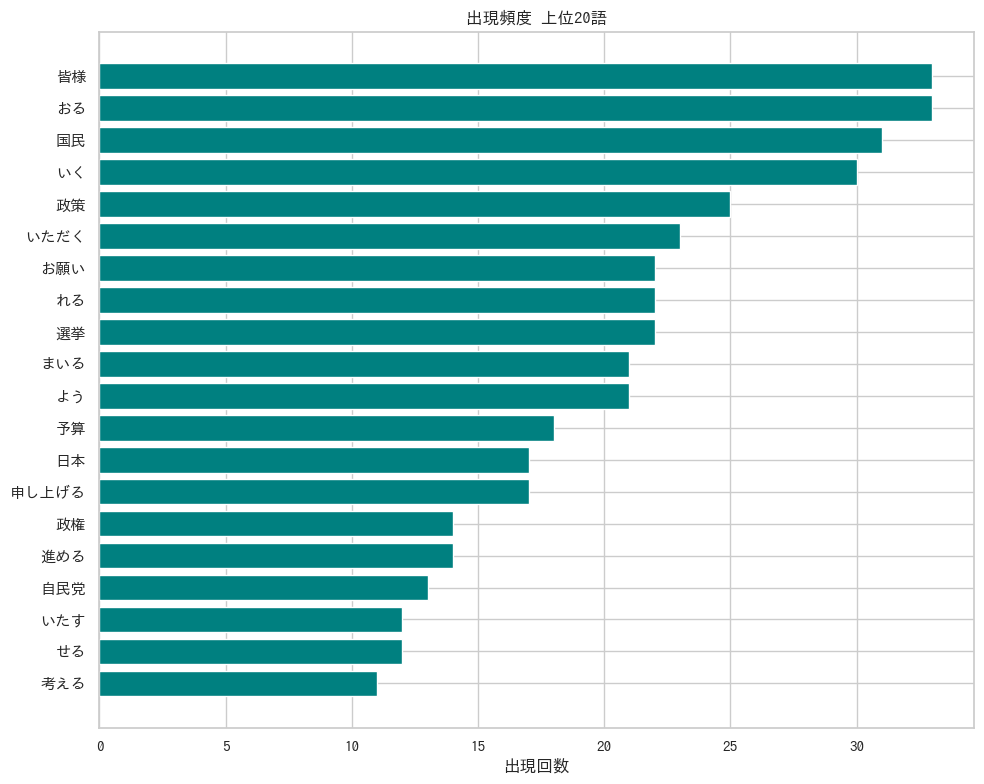

In [ ]:
# 上位20語を棒グラフ表示
top_n = 20
plot_df = freq_df.head(top_n).iloc[::-1]  # 見やすいように逆順

plt.figure(figsize=(10, 8))
plt.barh(plot_df["word"], plot_df["count"], color="teal")
plt.title(f"出現頻度 上位{top_n}語")
plt.xlabel("出現回数")
plt.tight_layout()
plt.show()


## 5. 共起ネットワーク分析
同じ文（`。！？` で区切る）に同時に出た語をつなぎ，関係の強さを可視化します。

### この分析で設定している主なパラメータ
- `TOP_WORDS_FOR_NETWORK`: 頻度上位何語をネットワーク対象にするか（多すぎると図が見づらくなる）
- `MIN_EDGE_WEIGHT`: 何回以上共起した語ペアだけを線として表示するか
- 文の区切り: `。！？` と改行で区切る（同じ文に出た語を「共起」とみなす）

### どのような分析をしているか
1. 全書き起こし文を文単位に分割
2. 各文から分析対象語（名詞・動詞・形容詞，不要語を除く）を抽出
3. 同じ文の中で同時に現れた語ペアを1回としてカウント
4. 文をまたいでカウントを合算し，共起回数の多いペアを抽出
5. `MIN_EDGE_WEIGHT` 以上のペアだけでネットワーク図を描画

### 調整の目安
- ノードが多すぎる: `TOP_WORDS_FOR_NETWORK` を下げる（例: 40 → 25）
- 線が多すぎる: `MIN_EDGE_WEIGHT` を上げる（例: 2 → 3）
- 線が少なすぎる: `MIN_EDGE_WEIGHT` を下げる（例: 2 → 1）

In [ ]:
# 頻度上位語だけをネットワーク対象にすると，図が見やすくなります
TOP_WORDS_FOR_NETWORK = 50
MIN_EDGE_WEIGHT = 2
SENTENCE_SPLIT_PATTERN = r"[。！？\n]"

target_words = set(freq_df.head(TOP_WORDS_FOR_NETWORK)["word"].tolist())
sentences = re.split(SENTENCE_SPLIT_PATTERN, all_text)

pair_counter = Counter()

for sent in sentences:
    ws = [w for w in extract_words(sent) if w in target_words]

    # 同じ文で同じ語が複数回出ても，ここでは1回として扱う
    ws = sorted(set(ws))

    for a, b in itertools.combinations(ws, 2):
        pair_counter[(a, b)] += 1

cooc_df = pd.DataFrame(
    [(a, b, c) for (a, b), c in pair_counter.items()],
    columns=["word1", "word2", "count"]
).sort_values("count", ascending=False)

print(f"文の数: {len(sentences)}")
print(f"ネットワーク対象語数: {len(target_words)}")
print(f"観測された語ペア数: {len(cooc_df)}")

display(cooc_df.head(30))


文の数: 3
ネットワーク対象語数: 50
観測された語ペア数: 1225


,word1,word2,count
83,いたす,総裁,3
12,いく,会談,3
193,お願い,よう,3
452,れる,合わせる,3
746,合わせる,総裁,3
455,れる,外交,3
195,お願い,れる,3
458,れる,強化,3
566,会談,外交,3
45,いく,進める,3


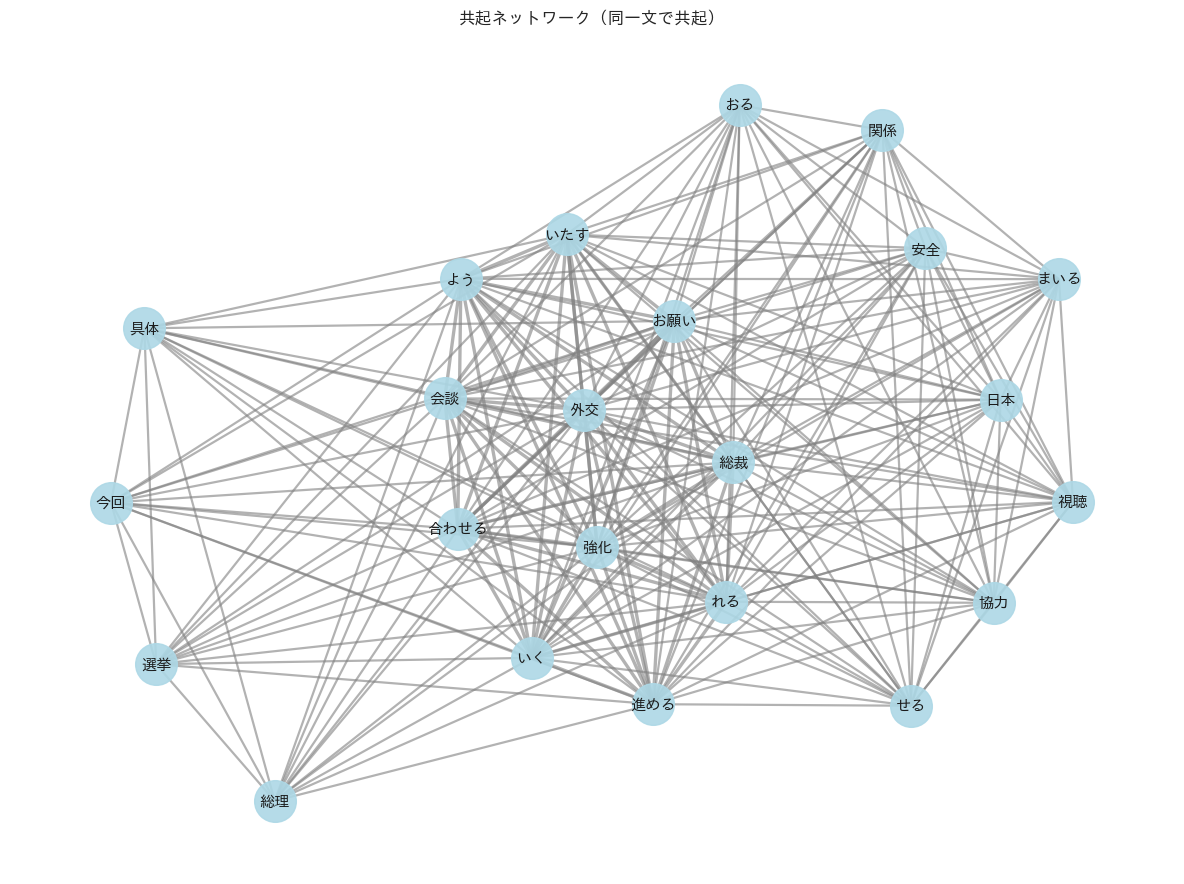

In [ ]:
# ネットワーク図の描画
edges_df = cooc_df[cooc_df["count"] >= MIN_EDGE_WEIGHT].copy()

G = nx.Graph()
for _, row in edges_df.iterrows():
    G.add_edge(row["word1"], row["word2"], weight=row["count"])

if G.number_of_nodes() == 0:
    print("条件を満たす共起ペアがありません。MIN_EDGE_WEIGHTを1に下げて再実行してください。")
else:
    plt.figure(figsize=(12, 9))

    pos = nx.spring_layout(G, k=0.9, seed=42)
    weights = [G[u][v]["weight"] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=900, node_color="lightblue", alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=[w * 0.8 for w in weights], alpha=0.6, edge_color="gray")
    nx.draw_networkx_labels(
        G,
        pos,
        font_size=11,
        font_family=JP_FONT_NAME if JP_FONT_NAME is not None else "sans-serif"
    )

    plt.title("共起ネットワーク（同一文で共起）")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


## 6. ワードクラウド作成
頻出語を視覚的に確認します。文字が大きいほど出現頻度が高いことを表します。

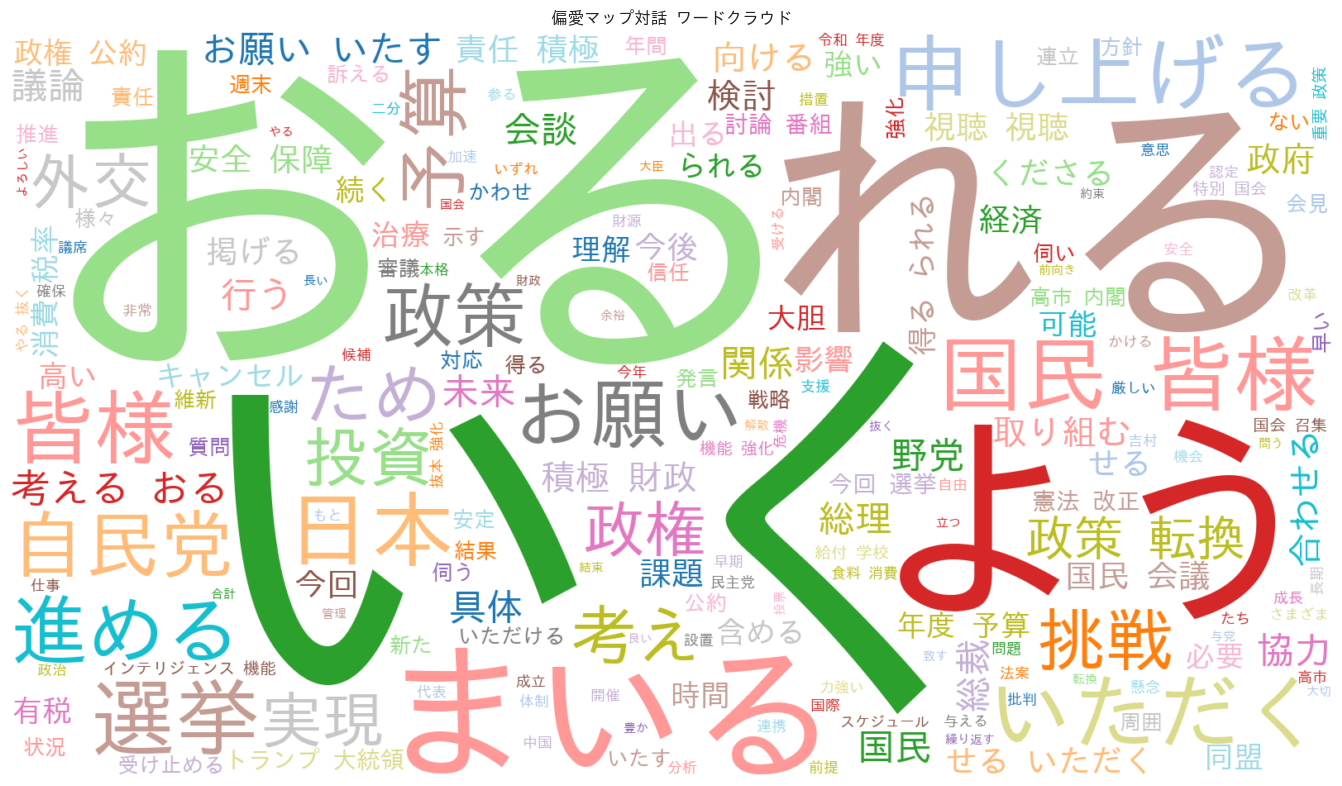

wordcloud.png を保存しました。


In [ ]:
# すでに設定済みの日本語フォントをワードクラウドにも利用
if JP_FONT_PATH is None:
    raise FileNotFoundError("日本語フォントが見つかりません。セットアップセルを再実行してください。")

font_path = JP_FONT_PATH

text_for_wc = " ".join(all_words)

wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    font_path=font_path,
    max_words=200,
    colormap="tab20"
).generate(text_for_wc)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("偏愛マップ対話 ワードクラウド")
plt.tight_layout()
plt.show()

wc.to_file("wordcloud.png")
print("wordcloud.png を保存しました。")


In [ ]:
# 生成物を保存
freq_df.to_csv("word_frequency.csv", index=False, encoding="utf-8-sig")
cooc_df.to_csv("co_occurrence_pairs.csv", index=False, encoding="utf-8-sig")

print("保存完了:")
print("- word_frequency.csv")
print("- co_occurrence_pairs.csv")
print("- wordcloud.png")


In [ ]:
# 必要ファイルをダウンロード
files.download("word_frequency.csv")
files.download("co_occurrence_pairs.csv")
files.download("wordcloud.png")


## 7. 結果の読み取りのヒント
- 頻度上位語: その人・ペアで強く語られた関心領域
- 共起ネットワーク: どの関心がセットで語られているか
- ワードクラウド: 全体の関心傾向の直感的把握

就活の自己分析では，
**頻出語 × 強い共起ペア** から「自分らしいテーマの組み合わせ」を言語化すると整理しやすくなります。

卒論テーマ探しでは，
**繰り返し出る語 + 具体例が多かった語** を候補にするのが有効です。

## 8. よくあるエラーと対処
- `音声ファイルが見つかりません`: アップロードセルで拡張子を確認
- 書き起こしが遅い: Colabの「ランタイム」→「ランタイムのタイプを変更」で `T4 GPU` を選択
- 日本語が文字化けする: セットアップセルを再実行してフォント導入を確認
- ネットワーク図が出ない: `MIN_EDGE_WEIGHT` を `1` に下げる

必要なら，分析単位を「全体」ではなく「参加者ごと」に分けて同じ処理を回すと，比較分析ができます。